## Notebook Setup and Uploading of Data to S3

In [192]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [193]:
!pip install -Uq altair torchtext torchdata

In [194]:
import sagemaker

In [195]:
!mkdir -p nn_src
import sys
sys.path.append('nn_src')

In [196]:
!touch nn_src/train_dummy
BUCKET = sagemaker.Session().default_bucket()
s3_data_url = f's3://{BUCKET}/nn/'
!aws s3 sync nn_src {s3_data_url} --exclude '*' --include 'train_dummy'

upload: nn_src/train_dummy to s3://sagemaker-eu-west-1-811243659808/nn/train_dummy


In [197]:
%%writefile nn_src/requirements.txt
torchtext
torchdata

Overwriting nn_src/requirements.txt


In [198]:
%%writefile nn_src/trenc.py

import math

import torch
from torch import nn
import torch.nn.functional as F 
from torch import log

class EncoderLayer(nn.Module):
    def __init__(self,
                 d,
                 num_heads,
                 dropout,
                 ff_dim, 
                 res_connections):

        super().__init__()

        projection_size = d // num_heads

        self.WQ = nn.Parameter(torch.randn(num_heads, d, projection_size)/math.sqrt(d))
        self.WK = nn.Parameter(torch.randn(num_heads, d, projection_size)/math.sqrt(d))
        self.WV = nn.Parameter(torch.randn(num_heads, d, projection_size)/math.sqrt(d))
        self.WO = nn.Parameter(torch.randn(num_heads, projection_size, d)/math.sqrt(d))

        self.attn_norm = nn.LayerNorm(d)
        self.ff_norm   = nn.LayerNorm(d)
        self.dropout   = nn.Dropout(p=dropout)
        self.ff        = nn.Sequential(
            nn.Linear(d, int(ff_dim*d)), 
            nn.GELU(),
            nn.Dropout(p=dropout),
            nn.Linear(int(ff_dim*d), d)
        )

        self.res_connections = res_connections
        # Why just one ReLU/GELU, one dropout? Attention is all you need: 4.3, 5.4. 
        
    def forward(self, input):

        X, prv_attention_values = input

        # b batch
        # t step
        # d dimension
        # p projected dimension
        # h head
        
        normalized_X = self.attn_norm(X) # Pre-Norm

        # Creating keys, queries and values from the normalized values, while
        # at the same time down projecting from d dimensions to p dimensions
        keys    = torch.einsum('btd,hdp->bthp', normalized_X, self.WK)
        queries = torch.einsum('btd,hdp->bthp', normalized_X, self.WQ)
        values  = torch.einsum('btd,hdp->bthp', normalized_X, self.WV)

        # Attention values are per position, not per dimension etc.
        dot = torch.einsum('bkhp,bqhp->bhqk', queries, keys)
        scaled_dot = dot / math.sqrt(values.size()[-1])
        attention_values = torch.softmax(scaled_dot, -1)

        assert torch.allclose(attention_values[0, 0, 0].sum(), torch.tensor(1.))

        new_values = torch.einsum('bkhp,bhqk->bqhp', values, attention_values)
        b, t, h, p = new_values.size()

        # Consolidate the invidual head outputs by concenating them
        # and then up projecting from p to d dimensions.
        seq_summary = torch.einsum('bthp,hpd->btd', new_values, self.WO)
        
        # Alternatively: 
        # Concat outputs of the individual heads
        # Using no learnable parameters
        # seq_summary = new_values.view(b, t, -1)

        assert seq_summary.size()[-1] == h*p == X.size()[-1]

        # Residual Connection and Pre-Norm
        if self.res_connections:
            pre_ff = X + self.ff_norm(seq_summary) 
        else:
            pre_ff = self.ff_norm(seq_summary) 

        prv_attention_values.append(attention_values)

        post_ff = self.ff(self.dropout(pre_ff))
        if self.res_connections:
            return post_ff + pre_ff, prv_attention_values
        else:
            return post_ff, prv_attention_values


class TrEnc(nn.Module):
    def __init__(self, 
                 num_classes, 
                 vocab_size, 
                 layers,
                 d,
                 heads,
                 dropout,
                 use_pos_enc,
                 use_cls_token,
                 clf_scale,
                 ff_dim, 
                 **kwargs):
        super().__init__()
        
        print(f'superfluous model parameters not used: {kwargs}')

        res_connections=True
        pos_encoding = 'sin' if use_pos_enc else None
        
        embed_size = d*heads 
        self.pooling  = 'cls' if use_cls_token else 'mean'
        
        self.res_connections = res_connections == True
  
        self.embeddings = nn.Embedding(vocab_size, embed_size, padding_idx=1)
        self.encoder_layers = \
            nn.Sequential(
                *[EncoderLayer(embed_size, heads, dropout, ff_dim, res_connections) for _ in range(layers)],)

        # Empricially it was a toss-up if the additional LN helped or not
        # It is part of the Pre-LN Transformer though
                #nn.LayerNorm(embed_size))
        
        # REVIEW: Just have one matrix for all three weight matrices?
        # REVIEW: Maybe do not project the values, but q and k only
        
        self.dropout     = nn.Dropout(dropout)
        
        if clf_scale:
            intermediate_dim = int(embed_size*clf_scale)
            self.clf = nn.Sequential(
                nn.Linear(embed_size, intermediate_dim, bias=False),
                nn.LayerNorm(intermediate_dim),
                nn.Tanh(),
                nn.Dropout(dropout/2),
                nn.Linear(intermediate_dim, num_classes)
            )
        else:
            self.clf = nn.Linear(embed_size, num_classes)
            
        self.pos_encoder = PositionalEncoding(embed_size, dropout) if use_pos_enc else None

    def extra_repr(self):
        return f'residual_connection={self.res_connections}, pooling={self.pooling}'

    def forward(self, X, output_attentions=False):
        # TODO: Unclear how helpful dropout on embeddings is here. Same p? 
        emb = self.dropout(self.embeddings(X))

        if self.pos_encoder:
            emb = self.pos_encoder(emb) 

        z, attention_values = self.encoder_layers((emb, []))
        
        if self.pooling == 'cls':
            logits = self.clf(self.dropout(z[:, 0]))
        elif self.pooling == 'mean':
            logits = self.clf(self.dropout(z.mean(1)))
        else:
            raise ValueError('Only mean and cls are valid valued for pooling.')

        if output_attentions:
            # return attention as b, l, h, q, k
            return logits, torch.stack(attention_values, 0).transpose(0, 1)
        return logits

# From: https://pytorch.org/tutorials/beginner/transformer_tutorial.html
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)


Overwriting nn_src/trenc.py


In [199]:
%%writefile nn_src/cnn.py

import torch
import torch.nn as nn
import torch.nn.functional as F

                
class CNN(nn.Module):
    def __init__(self,
                 vocab_size,
                 num_classes,
                 d, 
                 kernel_sizes,
                 num_filters,
                 strides,
                 dropout,
                 **kwargs):

        super().__init__()
        print(f'superfluous model parameters not used: {kwargs}')
        assert len(num_filters) == len(kernel_sizes) == len(strides), 'Same number of values for kernel_sizes, num_filters and strides must be specified.'
       
        self.embeddings = nn.Embedding(vocab_size, d, padding_idx=1)
        
        layers = []
        layers.append(Multihead([self._create_conv(
            d, 
            num_filters[i], 
            kernel_sizes[i], 
            dropout, 
            strides[i]
        ) for i in range(len(kernel_sizes))]))
        
        ff_in = sum(num_filters)
        
        self.nn = nn.Sequential(
            *layers,
            nn.BatchNorm1d(ff_in),
            MaxOverTimePooling(),
            nn.Linear(ff_in, num_classes))

    def forward(self, X):
        emb = self.embeddings(X).transpose(2, 1)
        
        return self.nn(emb)

    def _create_conv(self,
                     in_channels,
                     out_channels,
                     kernel_size,
                     dropout,
                     stride):
        
        padding = int((kernel_size-1)//2)
        
        return nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size, stride, padding),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(),
            nn.Dropout(p=dropout))

class MaxOverTimePooling(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        return torch.max(x, -1)[0]

class Cat(nn.Module):
    def __init__(self, dim=0):
        super().__init__()
        self.dim = dim
    def forward(self, x):
        return torch.cat(x, dim=self.dim)
    def extra_repr(self):
        return str(f'dim={self.dim}')

class Multihead(nn.Module):
    def __init__(self, heads, dim=1):
        super().__init__()
        self.heads = nn.ModuleList(heads)
        self.cat = Cat(dim)

    def forward(self, x):
        outputs = [head(x) for head in self.heads]
        return self.cat(outputs)


Overwriting nn_src/cnn.py


In [200]:
%%writefile nn_src/util.py

from ast import literal_eval

def count_parameters(m, verbose=True):
    total_count = 0
    learnable_count = 0
    if verbose:
        print('Parameters (name, tunable, count):')
    for n, p in m.named_parameters():
        count = p.data.numel() 
        if verbose:
            print(f' {n:60s} {p.requires_grad:5b} {count:>9d}')
        total_count += count
        if p.requires_grad:
            learnable_count += count
    if verbose:
        print(f'Total parameters: {total_count}, thereof learnable: {learnable_count}')
    return total_count, learnable_count

def str2bool(v):
    if isinstance(v, bool):
        return v
    if v.lower() in ('yes', 'true', 't', 'y', '1'):
        return True
    elif v.lower() in ('no', 'false', 'f', 'n', '0'):
        return False
    else:
        raise argparse.ArgumentTypeError('Boolean value expected.')
        
def str2ints(v):
    assert isinstance(v, str)
    
    obj = literal_eval(v)
    assert isinstance(obj, list), f'parsed value needs to be a list, not {type(obj)}'
    for elem in obj:
        assert isinstance(elem, int)
    
    return obj

Overwriting nn_src/util.py


In [201]:
%%writefile nn_src/train.py

import sys
import argparse
import random
import math
from time import time

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchdata.datapipes as dp

from torchtext.datasets import IMDB
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

from util import str2bool, str2ints, count_parameters
from trenc import TrEnc
from cnn import CNN

def parse_args(arg_values_to_parse):
    parser = argparse.ArgumentParser()

    parser.add_argument('--epochs', type=int, default=1) 
    parser.add_argument('--early-stopping-patience', type=int, default=0)
    parser.add_argument('--batch-size', dest='bs', type=int, default=32) 
    parser.add_argument('--lr', type=float, default=5e-5) 
    
    parser.add_argument('--model', type=str, default='TrEnc')
    parser.add_argument('--vocab-size',    type=int, default=10_000) 
    parser.add_argument('--max-input-len', type=int, default=64) 
    
    # model
    parser.add_argument('--dropout', dest='m_dropout',type=float, default=0.2) 
    parser.add_argument('--layers',  dest='m_layers',type=int, default=1) 
  
    # dim is used for embedings. If a TrEnc, then embed_size = dim*heads
    parser.add_argument('--dim', dest='m_d',     type=int, default=64) 
    
    # model trenc
    parser.add_argument('--heads',   dest='m_heads', type=int, default=8) 
    parser.add_argument('--ff-dim',  dest='m_ff_dim',type=float, default=4.) 
    parser.add_argument('--use-cls-token', dest='m_use_cls_token', type=str2bool, default=True)
    parser.add_argument('--use-pos-enc',   dest='m_use_pos_enc',   type=str2bool, default=False)
    parser.add_argument('--clf-scale',     dest='m_clf_scale', type=float, default=1.0)
    
    # model cnn
    parser.add_argument('--kernel-sizes', dest='m_kernel_sizes', type=str2ints, default='[1, 3]')
    parser.add_argument('--num-filters',  dest='m_num_filters',  type=str2ints, default='[48, 48]')
    parser.add_argument('--strides',      dest='m_strides',      type=str2ints, default='[1, 1]')
    
    parser.add_argument('--dummy', dest='_ignore',type=float, default=0.) 
    
    
    # FIXME: Should I add a separate pooler?
        
    return parser.parse_args(arg_values_to_parse)

def main(*arg_values_to_parse):
    
    args = parse_args([str(la) for la in arg_values_to_parse])
    print('Arguments:', args)
  
    dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    
    ### Data
    train_dp, valid_dp = IMDB(root='imdb_data', split=('train', 'test'))
    
    ### Built vocab and tokenizer
    tokenizer = get_tokenizer('basic_english')

    vocab = build_vocab_from_iterator(
        map(tokenizer, (text for (_, text) in train_dp)), specials=['<UNK>', '<PAD>'], 
        max_tokens=args.vocab_size
    )
    vocab.set_default_index(vocab['<UNK>'])
    
    print(f'Vocabulary built with {len(vocab.get_itos())} tokens.')
    
    ### Data Loader
    def vectorize(y, x):
        y = 0 if y == 'neg' else 1
        return (y, vocab(tokenizer(x)))
    
    def collate(data):
        batch_len = min(args.max_input_len, max([len(x) for (_, x) in data]))
        
        padding = [1] * batch_len # <PAD> has index 1
        y, x = zip(*[(y, (x+padding)[:batch_len]) for (y, x) in data])
 
        return torch.LongTensor(y).to(dev), torch.LongTensor(x).to(dev)
    
    train_dl = DataLoader(
        dataset=[vectorize(y, x) for (y, x) in train_dp], 
        batch_size=args.bs, 
        shuffle=True,
        drop_last=True,
        collate_fn=collate)
    del train_dp
    
    valid_ds = [vectorize(y, x) for (y, x) in valid_dp]
    random.shuffle(valid_ds)
    valid_dl = DataLoader(
        dataset=valid_ds[:7500], 
                batch_size=args.bs*2,
                collate_fn=collate)  
    del valid_dp
    del valid_ds
    
    ### Model
    # Instantiate model and pass all command line args that start with m_
    model_args = {
        'num_classes': 2, # neg, pos 
        'vocab_size': len(vocab.get_itos()),
        **{k[2:]: v for k, v in vars(args).items() if k.startswith('m_')}
    }
    
    
    model_cls = None
    if args.model == 'TrEnc':
        model_cls = TrEnc
    elif args.model == 'CNN':
        model_cls = CNN
    
    model = model_cls(**model_args).to(dev)

    print('Model instantiated:', model)

    # prints 'learnable: ddd' to stdout
    count_parameters(model)[1]
    
    ### Train Loop
    optimizer = torch.optim.AdamW(model.parameters(), lr=args.lr)
    criterion = nn.CrossEntropyLoss(reduction='sum')
        
    scaler = torch.cuda.amp.GradScaler()
    
    best_valid_loss = math.inf
    best_epoch = None
    
    #FIXME: documentation.
    best_result_store = None 
    
    for epoch in range(args.epochs):
        model.train()
        train_loss_epoch = 0.
        train_count_epoch = 0
        started = time()
    
        for i, (Yb, Xb) in enumerate(train_dl): 
            
            with torch.cuda.amp.autocast():
                logits = model(Xb)
            
                loss = criterion(logits, Yb)
            
            scaler.scale(loss).backward()
            
            scaler.step(optimizer)
            scaler.update()
            
            train_loss_epoch  += loss.item() 
            train_count_epoch += len(Yb)
            optimizer.zero_grad()

            if i % 50 == 0: 
                print(f'i: {i:4d}: batch_train_loss: {loss/len(Yb):6.4f}')
                
        model.eval()
        with torch.no_grad():
            valid_count_epoch = 0
            matched_epoch = 0
            valid_loss_epoch = 0.
            
            for i, (Yb, Xb) in enumerate(valid_dl):
                with torch.cuda.amp.autocast():
                    logits = model(Xb)
                    valid_loss_epoch += criterion(logits, Yb).item()
                    
                    predictions = logits.argmax(-1)
                    matched_epoch += (predictions == Yb).sum().item()
                    valid_count_epoch += len(Yb)

            acc = matched_epoch/valid_count_epoch
        
        log_message = f'ep: {epoch} train_loss: {train_loss_epoch/train_count_epoch:6.5f} valid_loss: {valid_loss_epoch/valid_count_epoch:6.5f} valid_acc: {acc:5.4f} took: {time()-started:5.3f}s'
        print(log_message)
        
        if valid_loss_epoch < best_valid_loss:
            best_valid_loss = valid_loss_epoch
            best_result_store = log_message
            best_epoch = epoch
            
            print(f'epoch {epoch} was the best epoch so far.')
            
        # early stopping 
        print(f'best epoch {best_epoch}, epoch {epoch}, diff {(epoch-best_epoch)}')
        if best_epoch and epoch >= args.early_stopping_patience-1 and (epoch-best_epoch) >= args.early_stopping_patience:
            print(f'No progress for {args.early_stopping_patience} epochs. Stopping early.')
            break
                
    print('End of training.')
    print('Re-reporting best loss epoch:')
    print(best_result_store)

if __name__ == '__main__':
    print('main', sys.argv)
    main(*sys.argv[1:])    

Overwriting nn_src/train.py


!0!2.0
!1!1.5
!2!1.3
!3!1.3 (last improvement)
!4!1.4
!5!1.5
!6!1.6



In [ ]:
# Uncomment the following line when you want to test your script locally (validate arg parsing for example)
#!python nn_src/train.py --epochs 20 --kernel-sizes '[1, 3]' --model 'CNN' --dim 32 --strides '[1, 1]' --num-filters '[12, 12]'

In [334]:
# Uncomment below to directly call the implementation. 
# To check if you have typos or mismatched dimensions, before you submit it to a container training.
# But also for example use PDB.
from nn_src.train import main as fit
fit('--epochs', 20,
    '--vocab-size', 1_000,
    '--batch-size', 128,
    '--lr', 1e-1, 
    '--layers', 1,
    '--dim', 8,
    '--ff-dim', 4,
    '--heads', 4,
    '--max-input-len', 64,
    '--early-stopping-patience', 2,
    '--clf-scale', 0.,
    '--model', 'CNN',
    '--dim', 32,
    '--strides', [1, 1],
    '--num-filters', [12, 12],
    '--kernel-sizes', [1, 2]
)

Arguments: Namespace(epochs=20, early_stopping_patience=2, bs=128, lr=0.1, model='CNN', vocab_size=1000, max_input_len=64, m_dropout=0.2, m_layers=1, m_d=32, m_heads=4, m_ff_dim=4.0, m_use_cls_token=True, m_use_pos_enc=False, m_clf_scale=0.0, m_kernel_sizes=[1, 2], m_num_filters=[12, 12], m_strides=[1, 1], _ignore=0.0)
Vocabulary built with 1000 tokens.
superfluous model parameters not used: {'layers': 1, 'heads': 4, 'ff_dim': 4.0, 'use_cls_token': True, 'use_pos_enc': False, 'clf_scale': 0.0}
Model instantiated: CNN(
  (embeddings): Embedding(1000, 32, padding_idx=1)
  (nn): Sequential(
    (0): Multihead(
      (heads): ModuleList(
        (0): Sequential(
          (0): Conv1d(32, 12, kernel_size=(1,), stride=(1,))
          (1): BatchNorm1d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Dropout(p=0.2, inplace=False)
        )
        (1): Sequential(
          (0): Conv1d(32, 12, kernel_size=(2,), stride=(1,))
          (1):

RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 64 but got size 63 for tensor number 1 in the list.

In [335]:
%debug

> /Users/mkamp/code/amazon-sagemaker-amt-visualize/nn_src/cnn.py(73)forward()
     71         self.dim = dim
     72     def forward(self, x):
---> 73         return torch.cat(x, dim=self.dim)
     74     def extra_repr(self):
     75         return str(f'dim={self.dim}')



ipdb>  p(x[0].shape, x[1].shape)


(torch.Size([128, 12, 64]), torch.Size([128, 12, 63]))


ipdb>  torch.cat(x)


*** RuntimeError: Sizes of tensors must match except in dimension 0. Expected size 64 but got size 63 for tensor number 1 in the list.


ipdb>  q


In [ ]:
xxx

In [202]:
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role

In [203]:
metric_definitions = [
    {'Name': 'Epoch',               'Regex': r'ep:\s+(-?[0-9\.]+)'},
    {'Name': 'Valid:Acc',           'Regex': r'valid_acc:\s+(-?[0-9\.]+)'},
    {'Name': 'Train:Loss',          'Regex': r'train_loss:\s+(-?[0-9\.]+)'},
    {'Name': 'Valid:Loss',          'Regex': r'valid_loss:\s+(-?[0-9\.]+)'}, 
    {'Name': 'LearnableParameters', 'Regex': r'learnable:\s+(-?[0-9\.]+)'} 
]                                 

In [327]:
estimator = PyTorch(
    'train.py',
    source_dir='nn_src',
    role=get_execution_role(),
    instance_type= 'ml.g4dn.xlarge',
    instance_count=1,
    framework_version='1.10',
    py_version='py38',
    metric_definitions=metric_definitions,
    base_job_name='nn',

    use_spot_instances= True,
    max_run=  60 * 60 * 24,
    max_wait= 60 * 60 * 24,

    keep_alive_period_in_seconds= 120,

    hyperparameters = {'early-stopping-patience': 5, 
                       'epochs': 20,
                       'batch-size': 128,
                       'lr': 2e-4,
                       'vocab-size': 4_000,
                       'heads': 12,
                       'dim': 32, 
                       'max-input-len': 256,
                       'layers': 1,
                       'dropout': 0.25, 
                       'use-cls-token': True,
                       'use-pos-enc': True,
                       'clf-scale': 1.,
                       'ff-dim': 4.,
                       
                       'model': 'CNN', # 'TrEnc', 'CNN'
                       'dim': 128,
                       'max-input-len': 2048,
                       'strides': '\'[1, 1, 1]\'',
                       'num-filters': '\'[12, 12, 12]\'',
                       'kernel-sizes': '\'[1, 3, 7]\'',
                      }
    ) 

In [328]:
estimator.fit({'train': s3_data_url+'train_dummy'}, wait=False)

### Automatic Model Tuning Jobs
#### Random Sweep to check the lay of the land

In [315]:
from sagemaker.tuner import IntegerParameter, CategoricalParameter
from sagemaker.tuner import ContinuousParameter, HyperparameterTuner
# next: vocab-size

hpt_ranges = {
    #'dummy': ContinuousParameter(0, 1, 'Linear'), 
    #'vocab-size': IntegerParameter(1_00, 10_000, 'Linear'),
    #'lr': ContinuousParameter(1e-6, 1e-2), 
    'max-input-len': IntegerParameter(10, 768),
    #'dropout': ContinuousParameter(0.2, 0.6),
    #'heads': IntegerParameter(4, 16),
    #'dim': IntegerParameter(8, 128),
    #'ff-dim': ContinuousParameter(0.1, 10, 'Linear'),
    #'layers': IntegerParameter(1, 12),
    #'layers': CategoricalParameter([1, 4, 8]),
    #'model': CategoricalParameter(['SentimentNN', 'TrEnc']),
    #'use-pos-enc': CategoricalParameter([True, False]),
    #'use-cls-token': CategoricalParameter([True, False])
    #'clf-scale': CategoricalParameter([0.5, 2.0])
}

tuner_parameters = {'estimator': estimator,
                    'base_tuning_job_name': 'cnn-in-len',
                    'metric_definitions': metric_definitions,
                    
                    'objective_metric_name': 'Valid:Acc',
                    'objective_type': 'Maximize',
                    'hyperparameter_ranges': hpt_ranges,
                    'strategy': 'Random',
                    'early_stopping_type': 'Off',
                    
                    'max_jobs': 20,           # Was: 20 
                    'max_parallel_jobs': 1}   # Was: 20

In [316]:
tuner = HyperparameterTuner(**tuner_parameters)
tuner.fit({'train': s3_data_url+'train_dummy'}, wait=False)
tuner_name = tuner.describe()["HyperParameterTuningJobName"]
print(f'tuning job submitted: {tuner_name}.')

tuning job submitted: cnn-in-len-221023-1755.


In [ ]:
# ClientError: An error occurred (ValidationException) when calling the CreateHyperParameterTuningJob operation: You don't have enough combinations of hyperparameter ranges. The total number of hyperparameter combinations for the provided ranges [6.0] must be equal or greater than the value of MaxNumberOfJobs, [75]. Provide additional ranges.
# which means I cannot use warm start, nor can I use Bayesian

In [339]:
# trenc

model      = 'model-221020-1931'
layers     = 'layers-221020-1931'
md_lr      = ['model-lr-tr-221020-2000', 'model-lr-nn-221020-2001', 'model-lr-nn-221021-1022']
pos_enc    = 'pos-enc-221020-2003'
pos_enc_lr = ['pe-t-lr-221020-2140', 'pe-f-lr-221020-2141']
ff_dim     = ['ff-dim-221021-1242']
dropout    = 'dropout-221021-1541'
input_len  = 'input-len-221021-1542'
vocab_size = 'input-len-221021-1631'
beefy_c_l  = ['beefy-layers-221021-2041', 'beefy-layers-221022-1013'] # and multi layers
beefy_c_l  = 'beefy-layers-221022-1013'
clf_scl_la = ['clf-scale-la-221022-1317', 'clf-scale-la-221022-2248'] # and multi layers

# cnn
sweep      = 'cnn-sweep-221021-1921'
inp_len    = ['cnn-in-len-221023-1140', 'cnn-in-len-221023-1755']
inp_len2    = [ 'cnn-in-len-221023-1755']

Tuning job cnn-in-len-221023-1755    status: InProgress

Number of training jobs with valid objective: 14
Lowest: 0.7849000096321106 Highest 0.8639000058174133


max-input-len                      TrainingJobName TrainingJobStatus   TrainingStartTime     TrainingEndTime  TrainingElapsedTimeSeconds           TuningJobName  Valid:Acc
6           481.0  cnn-in-len-221023-1755-009-bb0c257d         Completed 2022-10-23 17:17:48 2022-10-23 17:25:06                       438.0  cnn-in-len-221023-1755     0.8639
11          510.0  cnn-in-len-221023-1755-004-436060e0         Completed 2022-10-23 16:27:14 2022-10-23 16:34:08                       414.0  cnn-in-len-221023-1755     0.8624
10          576.0  cnn-in-len-221023-1755-005-1f89de43         Completed 2022-10-23 16:37:43 2022-10-23 16:44:42                       419.0  cnn-in-len-221023-1755     0.8556
3           640.0  cnn-in-len-221023-1755-012-0fe46cef         Completed 2022-10-23 17:45:30 2022-10-23 17:52:43                       433.0  cnn-in-len-221023-1755     0.8539
1           403.0  cnn-in-len-221023-1755-014-afb7e44a         Completed 2022-10-23 18:06:16 2022-10-23 18:13:24                       428.0  cnn-in-len-221023-1755     0.8525
9           606.0  cnn-in-len-221023-1755-006-a1fe6004         Completed 2022-10-23 16:47:08 2022-10-23 16:54:20                       432.0  cnn-in-len-221023-1755     0.8508
12          457.0  cnn-in-len-221023-1755-003-6d965aa8         Completed 2022-10-23 16:17:04 2022-10-23 16:24:07                       423.0  cnn-in-len-221023-1755     0.8495
8           585.0  cnn-in-len-221023-1755-007-b9ba05c3         Completed 2022-10-23 16:57:41 2022-10-23 17:05:00                       439.0  cnn-in-len-221023-1755     0.8397
7           314.0  cnn-in-len-221023-1755-008-c28a05fa         Completed 2022-10-23 17:07:42 2022-10-23 17:14:53                       431.0  cnn-in-len-221023-1755     0.8375
13          175.0  cnn-in-len-221023-1755-002-e9e2b48e         Completed 2022-10-23 16:07:02 2022-10-23 16:13:56                       414.0  cnn-in-len-221023-1755     0.8268

Retrieving metrics cache Hit/Miss: HHHHHHHHHHHHHH
CPU times: user 651 ms, sys: 14.9 ms, total: 666 ms
Wall time: 1.53 s


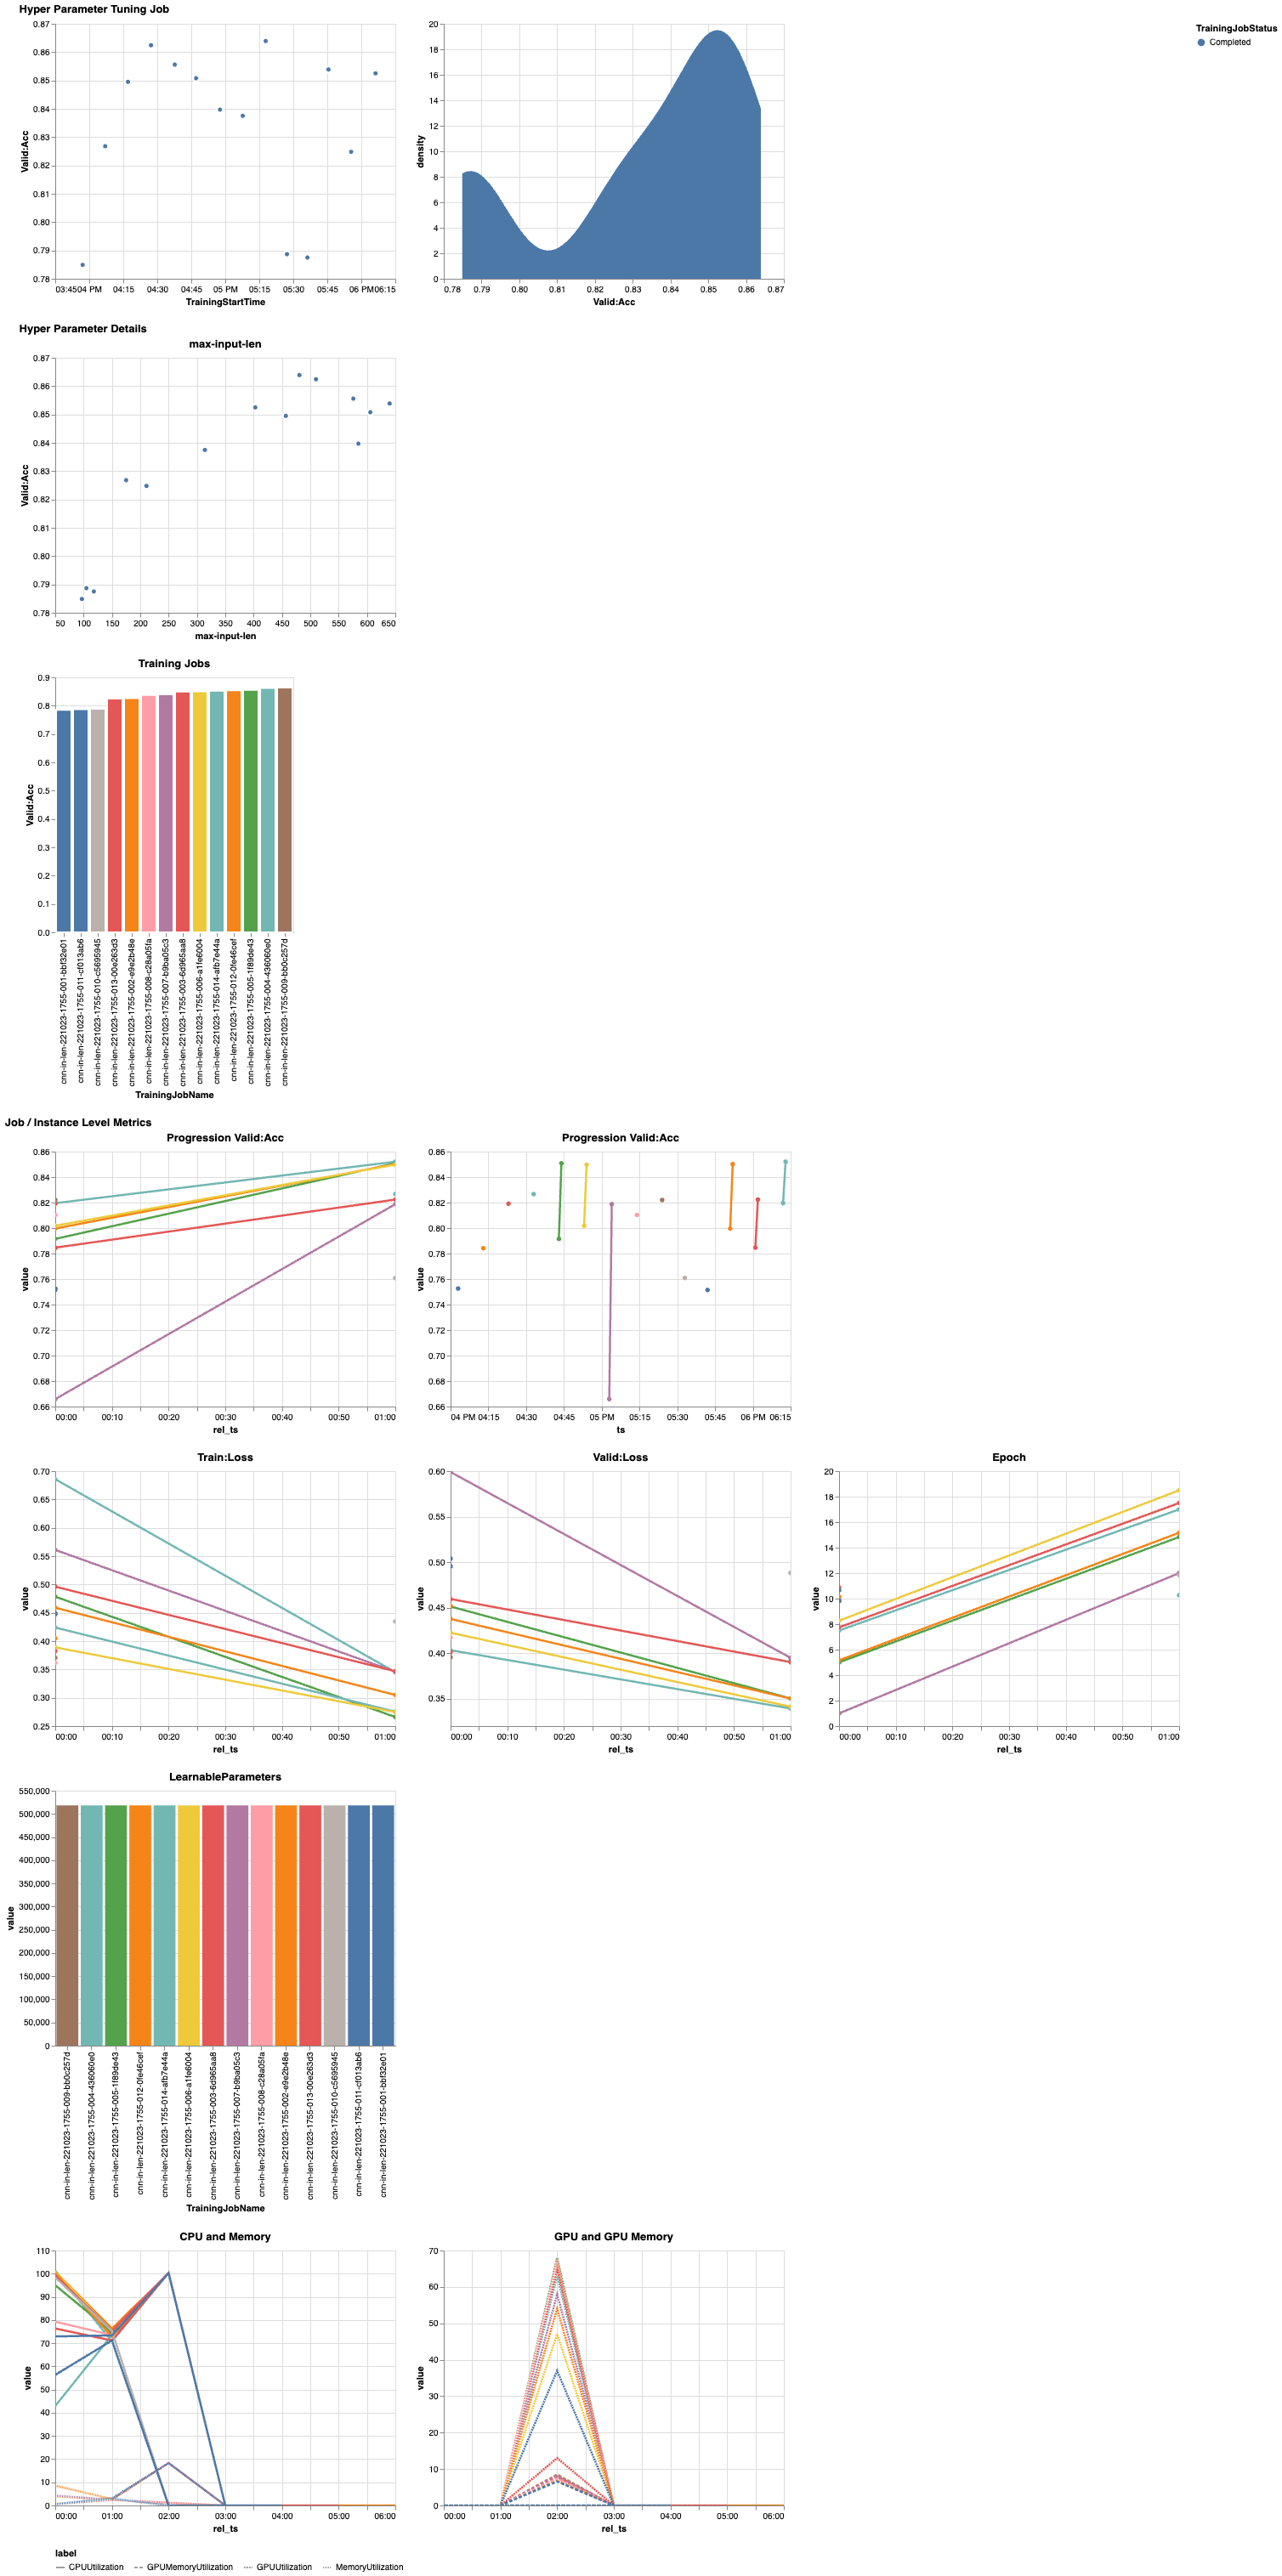

In [340]:
%%time
from reporting_util import analyze_hpo_job
chart, trials_df2, full_df2 = analyze_hpo_job(
    inp_len2, 
    return_dfs=True,
    job_metrics=[
        'Train:Loss',
        'Valid:Loss',
        'Epoch',
        'LearnableParameters'
    ]
)
chart 

In [ ]:
XXX

In [297]:
full_df2.dtypes

value                                float64
ts                                    object
label                                 object
rel_ts                                object
TrainingJobName                       object
max-input-len                        float64
TrainingJobStatus                     object
TrainingStartTime             datetime64[ns]
TrainingEndTime               datetime64[ns]
TrainingElapsedTimeSeconds           float64
TuningJobName                         object
Valid:Acc                            float64
dtype: object

In [294]:
full_df2.dtypes

value                                float64
ts                                    object
label                                 object
rel_ts                                object
TrainingJobName                       object
max-input-len                        float64
TrainingJobStatus                     object
TrainingStartTime             datetime64[ns]
TrainingEndTime               datetime64[ns]
TrainingElapsedTimeSeconds           float64
TuningJobName                         object
Valid:Acc                            float64
dtype: object

In [277]:
datetime.fromtimestamp(0)

datetime.datetime(1970, 1, 1, 1, 0)

In [275]:
#full_df2.ts

In [278]:
full_df2['ts'] = np.array(full_df2['ts'], dtype=np.datetime64)
full_df2['rel_ts'] = np.array(full_df2['rel_ts'], dtype=np.datetime64)

In [279]:
full_df2.dtypes

value                                           float64
ts                                       datetime64[ns]
label                                            object
rel_ts                                   datetime64[ns]
TrainingJobName                                  object
max-input-len                                   float64
TrainingJobStatus                                object
TrainingStartTime             datetime64[ns, tzlocal()]
TrainingEndTime               datetime64[ns, tzlocal()]
TrainingElapsedTimeSeconds                      float64
TuningJobName                                    object
Valid:Acc                                       float64
dtype: object

In [254]:
# from datetime import datetime
# datetime.fromtimestamp(0)+(full_df2['ts']-full_df2['ts'].min())

In [291]:
full_df2['ts']

0     2022-10-23 10:53:00
1     2022-10-23 10:52:00
2     2022-10-23 10:52:00
3     2022-10-23 10:53:00
4     2022-10-23 10:52:00
5     2022-10-23 10:53:00
6     2022-10-23 10:52:00
7     2022-10-23 10:53:00
8     2022-10-23 10:52:00
9     2022-10-23 10:53:00
10    2022-10-23 10:52:00
11    2022-10-23 10:57:00
12    2022-10-23 10:56:00
13    2022-10-23 10:55:00
14    2022-10-23 10:54:00
15    2022-10-23 10:53:00
16    2022-10-23 10:52:00
17    2022-10-23 10:51:00
18    2022-10-23 10:50:00
19    2022-10-23 10:57:00
20    2022-10-23 10:56:00
21    2022-10-23 10:55:00
22    2022-10-23 10:54:00
23    2022-10-23 10:53:00
24    2022-10-23 10:52:00
25    2022-10-23 10:51:00
26    2022-10-23 10:50:00
27    2022-10-23 10:57:00
28    2022-10-23 10:56:00
29    2022-10-23 10:55:00
30    2022-10-23 10:54:00
31    2022-10-23 10:53:00
32    2022-10-23 10:52:00
33    2022-10-23 10:51:00
34    2022-10-23 10:50:00
35    2022-10-23 10:57:00
36    2022-10-23 10:56:00
37    2022-10-23 10:55:00
38    2022-1

In [262]:
full_df2.dtypes

value                                           float64
ts                                       datetime64[ns]
label                                            object
rel_ts                                   datetime64[ns]
TrainingJobName                                  object
max-input-len                                   float64
TrainingJobStatus                                object
TrainingStartTime             datetime64[ns, tzlocal()]
TrainingEndTime               datetime64[ns, tzlocal()]
TrainingElapsedTimeSeconds                      float64
TuningJobName                                    object
Valid:Acc                                       float64
dtype: object

In [228]:
'2022-10-23T10:12:00.000000000Z'

'2022-10-23T10:12:00.000000000Z'

In [234]:
np.array(['2022-10-23T10:12:00.000000000Z', '2022-10-23T10:12:00.000000000Z'],dtype=np.datetime64)

array(['2022-10-23T10:12:00.000000000', '2022-10-23T10:12:00.000000000'],
      dtype='datetime64[ns]')

In [233]:
np.datetime64(np.array(['2022-10-23T10:12:00.000000000Z', '2022-10-23T10:12:00.000000000Z']))

ValueError: Could not convert object to NumPy datetime

In [236]:
#full_df2.dtypes

value                                           float64
ts                              datetime64[ns, tzutc()]
label                                            object
rel_ts                              datetime64[ns, UTC]
TrainingJobName                                  object
max-input-len                                   float64
TrainingJobStatus                                object
TrainingStartTime             datetime64[ns, tzlocal()]
TrainingEndTime               datetime64[ns, tzlocal()]
TrainingElapsedTimeSeconds                      float64
TuningJobName                                    object
Valid:Acc                                       float64
dtype: object

In [226]:
full_df2

value                              ts                 label                          rel_ts                      TrainingJobName  max-input-len TrainingJobStatus         TrainingStartTime           TrainingEndTime  TrainingElapsedTimeSeconds           TuningJobName  Valid:Acc
0         0.279295  2022-10-23T10:53:00.000000000Z            Train:Loss  1970-01-01T00:01:00.000000000Z  cnn-in-len-221023-1140-007-4e6cdddf         1942.0         Completed 2022-10-23 12:46:23+02:00 2022-10-23 12:54:12+02:00                       469.0  cnn-in-len-221023-1140     0.8601
1         0.445037  2022-10-23T10:52:00.000000000Z            Train:Loss  1970-01-01T00:00:00.000000000Z  cnn-in-len-221023-1140-007-4e6cdddf         1942.0         Completed 2022-10-23 12:46:23+02:00 2022-10-23 12:54:12+02:00                       469.0  cnn-in-len-221023-1140     0.8601
2    518314.000000  2022-10-23T10:52:00.000000000Z   LearnableParameters  1970-01-01T00:00:00.000000000Z  cnn-in-len-221023-1140-007-4e6cdddf         1942.0         Completed 2022-10-23 12:46:23+02:00 2022-10-23 12:54:12+02:00                       469.0  cnn-in-len-221023-1140     0.8601
3         0.347614  2022-10-23T10:53:00.000000000Z            Valid:Loss  1970-01-01T00:01:00.000000000Z  cnn-in-len-221023-1140-007-4e6cdddf         1942.0         Completed 2022-10-23 12:46:23+02:00 2022-10-23 12:54:12+02:00                       469.0  cnn-in-len-221023-1140     0.8601
4         0.473149  2022-10-23T10:52:00.000000000Z            Valid:Loss  1970-01-01T00:00:00.000000000Z  cnn-in-len-221023-1140-007-4e6cdddf         1942.0         Completed 2022-10-23 12:46:23+02:00 2022-10-23 12:54:12+02:00                       469.0  cnn-in-len-221023-1140     0.8601
5         0.851808  2022-10-23T10:53:00.000000000Z       ObjectiveMetric  1970-01-01T00:01:00.000000000Z  cnn-in-len-221023-1140-007-4e6cdddf         1942.0         Completed 2022-10-23 12:46:23+02:00 2022-10-23 12:54:12+02:00                       469.0  cnn-in-len-221023-1140     0.8601
6         0.778157  2022-10-23T10:52:00.000000000Z       ObjectiveMetric  1970-01-01T00:00:00.000000000Z  cnn-in-len-221023-1140-007-4e6cdddf         1942.0         Completed 2022-10-23 12:46:23+02:00 2022-10-23 12:54:12+02:00                       469.0  cnn-in-len-221023-1140     0.8601
7        13.500000  2022-10-23T10:53:00.000000000Z                 Epoch  1970-01-01T00:01:00.000000000Z  cnn-in-len-221023-1140-007-4e6cdddf         1942.0         Completed 2022-10-23 12:46:23+02:00 2022-10-23 12:54:12+02:00                       469.0  cnn-in-len-221023-1140     0.8601
8         3.428571  2022-10-23T10:52:00.000000000Z                 Epoch  1970-01-01T00:00:00.000000000Z  cnn-in-len-221023-1140-007-4e6cdddf         1942.0         Completed 2022-10-23 12:46:23+02:00 2022-10-23 12:54:12+02:00                       469.0  cnn-in-len-221023-1140     0.8601
9         0.851808  2022-10-23T10:53:00.000000000Z             Valid:Acc  1970-01-01T00:01:00.000000000Z  cnn-in-len-221023-1140-007-4e6cdddf         1942.0         Completed 2022-10-23 12:46:23+02:00 2022-10-23 12:54:12+02:00                       469.0  cnn-in-len-221023-1140     0.8601
10        0.778157  2022-10-23T10:52:00.000000000Z             Valid:Acc  1970-01-01T00:00:00.000000000Z  cnn-in-len-221023-1140-007-4e6cdddf         1942.0         Completed 2022-10-23 12:46:23+02:00 2022-10-23 12:54:12+02:00                       469.0  cnn-in-len-221023-1140     0.8601
11        0.000000  2022-10-23T10:57:00.000000000Z        CPUUtilization  1970-01-01T00:07:00.000000000Z  cnn-in-len-221023-1140-007-4e6cdddf         1942.0         Completed 2022-10-23 12:46:23+02:00 2022-10-23 12:54:12+02:00                       469.0  cnn-in-len-221023-1140     0.8601
12        0.000000  2022-10-23T10:56:00.000000000Z        CPUUtilization  1970-01-01T00:06:00.000000000Z  cnn-in-len-221023-1140-007-4e6cdddf         1942.0         Completed 2022-10-23 12:46:23+02:00 2022-10-23 12:54:12+02:00                 

In [218]:
full_df

value                              ts                 label                          rel_ts                      TrainingJobName  max-input-len TrainingJobStatus         TrainingStartTime           TrainingEndTime  TrainingElapsedTimeSeconds           TuningJobName  Valid:Acc
0         0.279295       2022-10-23 10:53:00+00:00            Train:Loss       1970-01-01 00:01:00+00:00  cnn-in-len-221023-1140-007-4e6cdddf         1942.0         Completed 2022-10-23 12:46:23+02:00 2022-10-23 12:54:12+02:00                       469.0  cnn-in-len-221023-1140     0.8601
1         0.445038       2022-10-23 10:52:00+00:00            Train:Loss       1970-01-01 00:00:00+00:00  cnn-in-len-221023-1140-007-4e6cdddf         1942.0         Completed 2022-10-23 12:46:23+02:00 2022-10-23 12:54:12+02:00                       469.0  cnn-in-len-221023-1140     0.8601
2    518314.000000       2022-10-23 10:52:00+00:00   LearnableParameters       1970-01-01 00:00:00+00:00  cnn-in-len-221023-1140-007-4e6cdddf         1942.0         Completed 2022-10-23 12:46:23+02:00 2022-10-23 12:54:12+02:00                       469.0  cnn-in-len-221023-1140     0.8601
3         0.347614       2022-10-23 10:53:00+00:00            Valid:Loss       1970-01-01 00:01:00+00:00  cnn-in-len-221023-1140-007-4e6cdddf         1942.0         Completed 2022-10-23 12:46:23+02:00 2022-10-23 12:54:12+02:00                       469.0  cnn-in-len-221023-1140     0.8601
4         0.473149       2022-10-23 10:52:00+00:00            Valid:Loss       1970-01-01 00:00:00+00:00  cnn-in-len-221023-1140-007-4e6cdddf         1942.0         Completed 2022-10-23 12:46:23+02:00 2022-10-23 12:54:12+02:00                       469.0  cnn-in-len-221023-1140     0.8601
5         0.851808       2022-10-23 10:53:00+00:00       ObjectiveMetric       1970-01-01 00:01:00+00:00  cnn-in-len-221023-1140-007-4e6cdddf         1942.0         Completed 2022-10-23 12:46:23+02:00 2022-10-23 12:54:12+02:00                       469.0  cnn-in-len-221023-1140     0.8601
6         0.778157       2022-10-23 10:52:00+00:00       ObjectiveMetric       1970-01-01 00:00:00+00:00  cnn-in-len-221023-1140-007-4e6cdddf         1942.0         Completed 2022-10-23 12:46:23+02:00 2022-10-23 12:54:12+02:00                       469.0  cnn-in-len-221023-1140     0.8601
7        13.500000       2022-10-23 10:53:00+00:00                 Epoch       1970-01-01 00:01:00+00:00  cnn-in-len-221023-1140-007-4e6cdddf         1942.0         Completed 2022-10-23 12:46:23+02:00 2022-10-23 12:54:12+02:00                       469.0  cnn-in-len-221023-1140     0.8601
8         3.428571       2022-10-23 10:52:00+00:00                 Epoch       1970-01-01 00:00:00+00:00  cnn-in-len-221023-1140-007-4e6cdddf         1942.0         Completed 2022-10-23 12:46:23+02:00 2022-10-23 12:54:12+02:00                       469.0  cnn-in-len-221023-1140     0.8601
9         0.851808       2022-10-23 10:53:00+00:00             Valid:Acc       1970-01-01 00:01:00+00:00  cnn-in-len-221023-1140-007-4e6cdddf         1942.0         Completed 2022-10-23 12:46:23+02:00 2022-10-23 12:54:12+02:00                       469.0  cnn-in-len-221023-1140     0.8601
10        0.778157       2022-10-23 10:52:00+00:00             Valid:Acc       1970-01-01 00:00:00+00:00  cnn-in-len-221023-1140-007-4e6cdddf         1942.0         Completed 2022-10-23 12:46:23+02:00 2022-10-23 12:54:12+02:00                       469.0  cnn-in-len-221023-1140     0.8601
11        0.000000       2022-10-23 10:57:00+00:00        CPUUtilization       1970-01-01 00:07:00+00:00  cnn-in-len-221023-1140-007-4e6cdddf         1942.0         Completed 2022-10-23 12:46:23+02:00 2022-10-23 12:54:12+02:00                       469.0  cnn-in-len-221023-1140     0.8601
12        0.000000       2022-10-23 10:56:00+00:00        CPUUtilization       1970-01-01 00:06:00+00:00  cnn-in-len-221023-1140-007-4e6cdddf         1942.0         Completed 2022-10-23 12:46:23+02:00 2022-10-23 12:54:12+02:00                 

In [223]:
full_df.dtypes

value                                           float64
ts                                               object
label                                            object
rel_ts                                           object
TrainingJobName                                  object
max-input-len                                   float64
TrainingJobStatus                                object
TrainingStartTime             datetime64[ns, tzlocal()]
TrainingEndTime               datetime64[ns, tzlocal()]
TrainingElapsedTimeSeconds                      float64
TuningJobName                                    object
Valid:Acc                                       float64
dtype: object

In [26]:
from torchtext.datasets import IMDB
train_dp = IMDB(root='imdb_data', split=('train'))

In [58]:
%%time
import re
import numpy as np
word_counts = np.array([len(re.findall(r'\w+', text)) for _, text in train_dp])
word_counts.shape, np.min(word_counts), np.median(word_counts), word_counts.mean()

CPU times: user 1.18 s, sys: 16.3 ms, total: 1.19 s
Wall time: 1.19 s


((25000,), 10, 181.0, 242.27492)

In [97]:
!pip install -Uq revtok spacy moses

In [175]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

tokenizer = get_tokenizer('basic_english')
word_counts_basic = np.array([len(tokenizer(text)) for _, text in train_dp])

#from torchtext.data.functional import sentencepiece_tokenizer

%time word_counts_subwords = np.array([len(np.array(list(sp_tokenizer([text]))).flatten()) for _, text in train_dp])

CPU times: user 9.93 s, sys: 79.2 ms, total: 10 s
Wall time: 10 s


In [219]:
trials_df

max-input-len                      TrainingJobName TrainingJobStatus         TrainingStartTime           TrainingEndTime  TrainingElapsedTimeSeconds           TuningJobName  Valid:Acc
1         1942.0  cnn-in-len-221023-1140-007-4e6cdddf         Completed 2022-10-23 12:46:23+02:00 2022-10-23 12:54:12+02:00                       469.0  cnn-in-len-221023-1140     0.8601
5          794.0  cnn-in-len-221023-1140-003-57d8e790         Completed 2022-10-23 12:04:42+02:00 2022-10-23 12:12:14+02:00                       452.0  cnn-in-len-221023-1140     0.8564
7         2685.0  cnn-in-len-221023-1140-001-b475b819         Completed 2022-10-23 11:42:42+02:00 2022-10-23 11:50:15+02:00                       453.0  cnn-in-len-221023-1140     0.8532
3         2553.0  cnn-in-len-221023-1140-005-70b24897         Completed 2022-10-23 12:26:28+02:00 2022-10-23 12:34:06+02:00                       458.0  cnn-in-len-221023-1140     0.8523
2          607.0  cnn-in-len-221023-1140-006-b11b9323         Completed 2022-10-23 12:37:04+02:00 2022-10-23 12:44:12+02:00                       428.0  cnn-in-len-221023-1140     0.8475
4         3907.0  cnn-in-len-221023-1140-004-a9d9f809         Completed 2022-10-23 12:14:34+02:00 2022-10-23 12:22:33+02:00                       479.0  cnn-in-len-221023-1140     0.8467
6         3136.0  cnn-in-len-221023-1140-002-6355c725         Completed 2022-10-23 11:52:12+02:00 2022-10-23 12:01:01+02:00                       529.0  cnn-in-len-221023-1140     0.8443

In [176]:
df_simple   = pd.DataFrame(data= {'label': 'simple', 'counts': word_counts})
df_basic    = pd.DataFrame(data= {'label': 'basic english', 'counts': word_counts_basic})
df_subwords = pd.DataFrame(data= {'label': 'subwords', 'counts': word_counts_subwords})

df = pd.concat((df_simple, df_basic, df_subwords), axis=0)

In [177]:
# tokenizer = get_tokenizer('subword')
# tokenizer('this is just an test to try out an attempt on a washingmachine unknownwird which is running.')

In [180]:
df.groupby('label').describe()

NameError: name 'x' is not defined

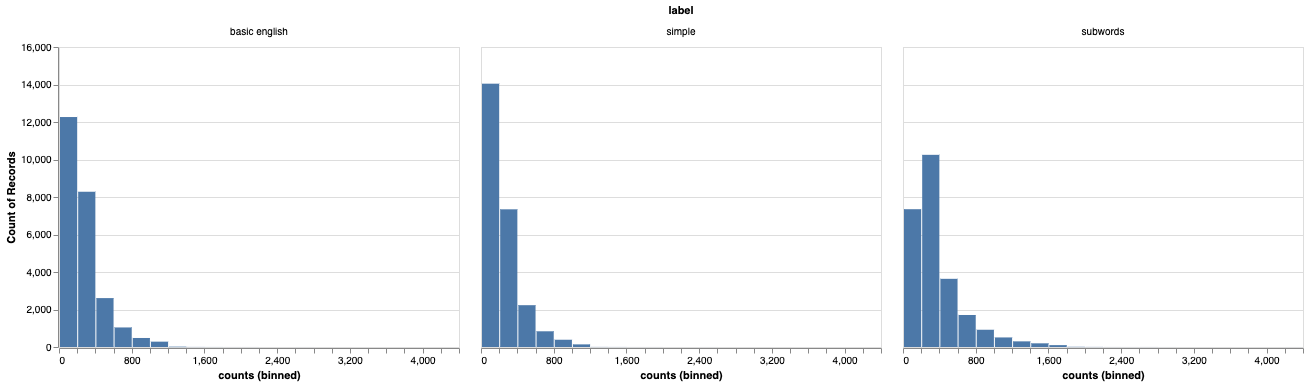

In [179]:
import altair as alt
import pandas as pd
# pd.DataFrame(data={'counts': word_counts}) 
alt.Chart(df).mark_bar().encode( 
    x=alt.X('counts:Q', bin=alt.Bin(maxbins=30), sort=None),
    y='count()',
    tooltip='median(counts)'   
).facet('label:N')

In [171]:
from pathlib import Path
input_file = Path('data')/'sp_input'
if not input_file.exists():
    with open(input_file, 'w') as f:
        for _, text in train_dp:
            f.write(text+'\n')

from torchtext.data.functional import generate_sp_model

%time generate_sp_model(str(input_file), vocab_size=4000, model_type='bpe')

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=data/sp_input --model_prefix=m_user --vocab_size=4000 --model_type=bpe
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: data/sp_input
  input_format: 
  model_prefix: m_user
  model_type: BPE
  vocab_size: 4000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos_id: 2
  pad_id: -1
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <pad>
  unk_surface:  ⁇ 
}


CPU times: user 4.52 s, sys: 56.1 ms, total: 4.57 s
Wall time: 3.95 s


In [174]:
from torchtext.data.functional import load_sp_model
sp_model = load_sp_model('m_user.model')

In [173]:
sp_tokenizer = sentencepiece_tokenizer(sp_model)
l = list(tokenizer(['one two three', 'four five six', 'example to try', 'washing machine running automation']))

AttributeError: 'list' object has no attribute 'lower'

In [163]:
l = [['a', 'b'], ['c', 'd']]

In [ ]:
[num for elem in vec for num in elem]

array(['a', 'b', 'c', 'd'], dtype='<U1')

In [ ]:
# sample 256 tokens from t, m, e